In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import integrate
import pandas as pd
from functools import partial
import models

## IRD model (FT model) under simple shear  
Ref: Folgar, F., and C. L. Tucker, “Orientation behavior of fibers in concentrated suspensions.” _J. Reinf. Plast. Compos._ **1984**, 3, 98–119.  
  
$$
\mathbf{\dot{A}}=\mathbf{\dot{A}}^{HD}+\mathbf{\dot{A}}^{IRD}
$$
Tensor type of the FT model:
$$
\mathbf{\dot{A}}=\mathbf{W\cdot A}-\mathbf{A\cdot W}+\xi(\mathbf{D\cdot A}+\mathbf{A\cdot D}-2\mathbf{A:D})+2C_I\dot \gamma(\mathbf I-3\mathbf{A})
$$
  
  
Here, for simple shear: 
$$
\mathbf{L}=\begin{pmatrix}
 0 & \dot\gamma &0 \\
 0 & 0 &0 \\
 0 & 0 &0
\end{pmatrix}
$$

<Axes: title={'center': 'IRD Model (FT Model) under simple shear'}, xlabel='Time (s)', ylabel='$\\mathbf{A}(t)$ Components'>

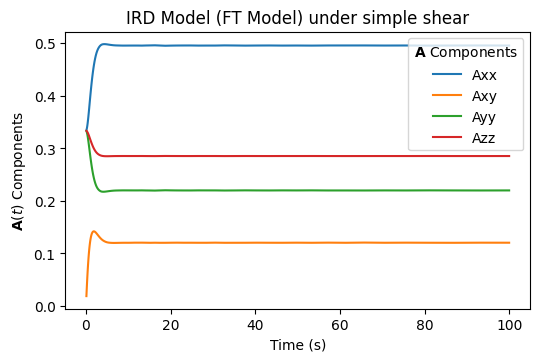

In [2]:
#####################################################
#parameters
CI=0.1
rho=10
shear_rate=1
#for simple shear, initial state is random oriented
a2_0=np.eye(3)/3
L=np.zeros((3,3),dtype=np.float64)
L[0,1]=shear_rate
#######################################################
#ODE function
fun=partial(models.FT_model.da2_fun_for_ode,CI=CI,L=L,rho=rho,a4_method='IBOF')
t_span=(0,100)
t_eval=np.logspace(-1,np.log10(t_span[1]),num=100)
res=integrate.solve_ivp(fun,t_span,a2_0.reshape((-1,)),method='RK45',t_eval=t_eval)
res_df=pd.DataFrame(res.y.T,index=res.t,columns=['Axx','Axy','Axz',\
                                                'Ayx','Ayy','Ayz',\
                                                'Azx','Azy','Azz'])
res_df.index.name=r'Time (s)'
res_df.columns.name=r'$\mathbf{A}$ Components'
res_df.plot(y=['Axx','Axy','Ayy','Azz'],title='IRD Model (FT Model) under simple shear', \
            ylabel = r"$\mathbf{A}(t)$ Components", figsize=(6,3.6))

# Caculate the stress $\mathbf{\sigma}(t)$ by Lipscomb Model
Ref: Lipscomb, G. G. et. al. “The flow of fiber suspensions in complex geometries.” _J. Non-Newtonian Fluid Mech._ **1988**, 26, 297–325. 

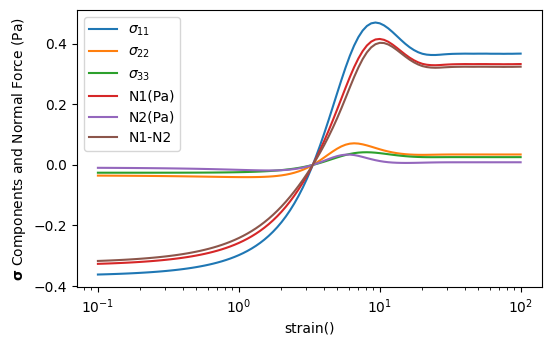

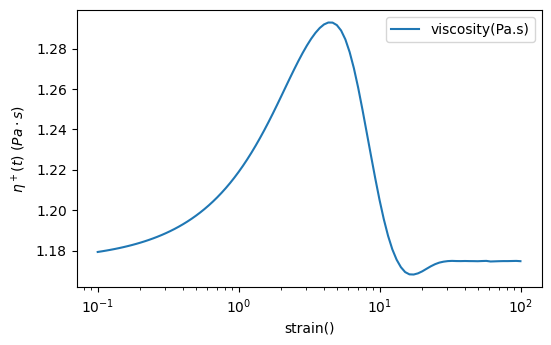

In [3]:
def cal_stress(a2_0,phi,strain,viscosity_0=1,shear_rate=1):
    L=np.zeros((3,3),dtype=np.float64)
    L[0,1]=shear_rate
    rho=32
    CI=0.0345*(1-np.exp(-0.483*rho*phi))
    #CI=0.03*(1-np.exp(-0.224*rho*phi))
    fun=partial(models.FT_model.da2_fun_for_ode,CI=CI,L=L,rho=rho,a4_method='IBOF')
    t_span=(0,strain/shear_rate)
    t_eval=np.logspace(-1,np.log10(t_span[1])*0.999,num=100)
    res=integrate.solve_ivp(fun,t_span,a2_0.reshape((-1,)),method='RK45',t_eval=t_eval)
    res_df=pd.DataFrame(res.y.T,index=res.t*shear_rate)
    res_df.index.name=r'strain()'
    #res_df.plot(title='simple shear',figsize=(14,10),logx=True)
    for ind,row in res_df.iterrows():
        a2=np.reshape(row.values[:9],[3,3])
        #a4=models.a4_IBOF.a4_IBOF(a2)
        a4=models.a4_ORW3.a4_ORW3(a2)
        sigma=models.stress_Lipscomb.stress_Lipscomb(viscosity_0,L=L,rho=rho,a2=a2,phi=phi,c1=0)
        res_df.loc[ind,'viscosity(Pa.s)']=sigma[0,1]/shear_rate
        res_df.loc[ind,'N1(Pa)']=sigma[0,0]-sigma[1,1]
        res_df.loc[ind,'N2(Pa)']=sigma[1,1]-sigma[2,2]
        res_df.loc[ind,'N1-N2']=sigma[0,0]+sigma[2,2]-2*sigma[1,1]
        res_df.loc[ind,r"$\sigma_{11}$"]=sigma[0,0]
        res_df.loc[ind,r"$\sigma_{12}$"]=sigma[0,1]
        res_df.loc[ind,r"$\sigma_{13}$"]=sigma[0,2]
        res_df.loc[ind,r"$\sigma_{22}$"]=sigma[1,1]
        res_df.loc[ind,r"$\sigma_{23}$"]=sigma[1,2]
        res_df.loc[ind,r"$\sigma_{33}$"]=sigma[2,2]
    return res_df

for wt_phi in [0.03]:
    phi=wt_phi/2.04/((1-wt_phi)/1.13+wt_phi/2.04)
    #forward shear
    a2_0=np.eye(3)/3
    res_df_forward=cal_stress(a2_0=a2_0,phi=phi,strain=100)
    #reversal shear
    a2_0_reversal=np.reshape(res_df_forward.iloc[-1,:9].values,[3,3])
    a2_0_reversal[0,1]=-a2_0_reversal[0,1]
    a2_0_reversal[1,0]=-a2_0_reversal[1,0]
    res_df_reversal=cal_stress(a2_0=a2_0_reversal,phi=phi,strain=100)
    #plot results
    res_df_reversal.plot(y=[r"$\sigma_{11}$",r"$\sigma_{22}$",r"$\sigma_{33}$",'N1(Pa)','N2(Pa)','N1-N2'], \
                         logx=True, ylabel = r"$\mathbf{\sigma}$ Components and Normal Force (Pa)", figsize=[6,3.6])
    res_df_reversal.plot(y=['viscosity(Pa.s)'], \
                         logx=True, ylabel = r"$\eta^+(t)\ (Pa\cdot s)$", figsize=[6,3.6])